In [153]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from PIL import Image
from transformers import AutoModel
from transformers import AutoVideoProcessor
import sklearn as sk
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt


In [4]:
hf_model_name = (
    "facebook/vjepa2-vitl-fpc64-256"  # Replace with your favored model, e.g. facebook/vjepa2-vitg-fpc64-384
)

# initialize model weights from huggingface
model_hf = AutoModel.from_pretrained(hf_model_name)
model_hf.to("mps", dtype = torch.float32).eval() 

# load model weights
hf_transform = AutoVideoProcessor.from_pretrained(hf_model_name)


In [ ]:
# creating scenes for testing encoder

tubelet_size = 2 # size of temporal data
data_dir = 'data'
tubelet_videos = [] # elements of (tubelet_size, H, W, 3)
tubelet_meta = [] # list of (scene_name, tubelet index within scene)

# ensure deterministic scene order
scene_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

for scene in scene_names:
    folder_path = os.path.join(data_dir, scene)
    frame_files = sorted(
        f for f in os.listdir(folder_path)
        if os.path.isfile(os.path.join(folder_path, f))
    )

    frames = [] 

    # ensure deterministic frame order within each scene
    for file in sorted(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, file)
        img = Image.open(img_path).convert("RGB")
        img = img.resize((224, 224), Image.BICUBIC) # resizing to work with masking (otherwise model will resize automatically)
        frames.append(np.array(img))

    # make non-overlapping tubeletes
    num_tubelets = len(frames) // tubelet_size
    for t_idx in range(num_tubelets):
        start = t_idx * tubelet_size
        tube = np.stack(frames[start:start + tubelet_size], axis = 0)
        tubelet_videos.append(tube)
        tubelet_meta.append((scene,  t_idx))

    
    print(f"{scene}: {len(frames)} frames -> {num_tubelets} tubelets")

scene1: 16 frames -> 8 tubelets
scene2: 16 frames -> 8 tubelets
scene3: 16 frames -> 8 tubelets
scene4: 16 frames -> 8 tubelets
scene5: 16 frames -> 8 tubelets
scene6: 16 frames -> 8 tubelets


In [ ]:
# ground truth clips (unmasked)

embeddings = [] # elements of (W, ) embedding vectors

for video in tubelet_videos:
    inputs = hf_transform(video, return_tensors = 'pt')
    inputs = {k: v.to(model_hf.device) for k, v, in inputs.items()}

    with torch.no_grad():
        feats = model_hf.get_vision_features(**inputs) # (1, H, W)
        print("feats shape ", feats.shape)
        clip_emb = feats.mean(dim=1).squeeze(0).cpu().numpy() # global average pooling for downstream
        print("clim emb shape ", clip_emb.shape)
        embeddings.append(clip_emb)  


tubelet_embds = np.stack(embeddings, axis = 0) # tensor of all our embeddings

feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])


In [43]:

def mask_tubelet_pixels(tubelet: np.ndarray,
                        mask_ratio: float = 0.75,
                        patch_size: int = 16,
                        seed: int | None = None,
                        fill_value: int = 0) -> tuple[np.ndarray, np.ndarray]:
    """Return a masked copy of ``tubelet`` and a boolean patch mask.

    Args:
        tubelet: numpy array shaped (T, H, W, 3) containing uint8 RGB frames.
        mask_ratio: fraction of spatio-temporal patches to hide.
        patch_size: spatial patch size, must divide both H and W.
        seed: optional RNG seed for reproducibility.
        fill_value: pixel value used to overwrite masked regions.

    Returns:
        masked_tubelet: numpy array with selected patches overwritten.
        mask_tokens: bool array of shape (T, H/patch_size, W/patch_size) marking masked patches.
    """

    assert 0.0 <= mask_ratio <= 1.0, "mask_ratio must be within [0, 1]"
    if tubelet.ndim != 4:
        raise ValueError(f"tubelet must be rank-4 (T, H, W, C), got shape {tubelet.shape}")

    T, H, W, C = tubelet.shape
    if H % patch_size != 0 or W % patch_size != 0:
        raise ValueError("H and W must be divisible by patch_size")

    masked = tubelet.copy()
    rng = np.random.default_rng(seed)
    h_tokens = H // patch_size
    w_tokens = W // patch_size
    tokens = [(t, h, w) for t in range(T)
              for h in range(h_tokens)
              for w in range(w_tokens)]

    mask_tokens = np.zeros((T, h_tokens, w_tokens), dtype=bool)

    rng.shuffle(tokens)
    k = int(round(mask_ratio * len(tokens)))
    k = min(max(k, 0), len(tokens))

    for t, h, w in tokens[:k]:
        h0 = h * patch_size
        w0 = w * patch_size
        masked[t, h0:h0 + patch_size, w0:w0 + patch_size] = fill_value
        mask_tokens[t, h, w] = True

    return masked, mask_tokens



In [95]:

# target clip embeddings (masked)

MASK_RATIO = 0.75
PATCH_SIZE = 16
masked_embeddings = []
mask_token_list = []

for idx, video in enumerate(tubelet_videos):
    video_masked, mask_tokens = mask_tubelet_pixels(video, mask_ratio=MASK_RATIO,
                                                   patch_size=PATCH_SIZE, seed=idx, fill_value=0)
    inputs = hf_transform(video_masked, return_tensors='pt')
    inputs = {k: v.to(model_hf.device) for k, v in inputs.items()}

    with torch.no_grad():
        feats = model_hf.get_vision_features(**inputs)
        print("feats shape ", feats.shape)
        clip_emb = feats.mean(dim=1).squeeze(0).cpu().numpy()
        print("clim emb shape ", clip_emb.shape)
        masked_embeddings.append(clip_emb)
        mask_token_list.append(mask_tokens)

if masked_embeddings:
    tubelet_embds_masked = np.stack(masked_embeddings, axis=0)
    tubelet_mask_tokens = np.stack(mask_token_list, axis=0)
    print('masked embeddings tensor', tubelet_embds_masked.shape)
    print('mask tokens tensor', tubelet_mask_tokens.shape)
else:
    tubelet_embds_masked = None
    tubelet_mask_tokens = None



feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])


In [98]:
# normalize
tubelet_embds_norm = tubelet_embds / np.linalg.norm(tubelet_embds)
tubelet_embds_masked_norm = tubelet_embds_masked / np.linalg.norm(tubelet_embds_masked)



In [99]:

# computing PCA 

# Select features X: prefer tubelet embeddings if present
if 'tubelet_embds_norm' in globals():
    X = tubelet_embds_norm  # (N_tubelets, D)
    meta = tubelet_meta
    use_tubelets = True
else:
    raise RuntimeError('tubelet_embds_norm not found')

pca3 = sk.decomposition.PCA(n_components=3)
emb_3d = pca3.fit_transform(X)

pca2 = sk.decomposition.PCA(n_components = 2)
emb_2d = pca2.fit_transform(X)

emb_3d_masked = None
emb_2d_masked = None
if 'tubelet_embds_masked_norm' in globals() and tubelet_embds_masked_norm is not None:
    emb_3d_masked = pca3.transform(tubelet_embds_masked_norm)
    emb_2d_masked = pca2.transform(tubelet_embds_masked_norm)



/var/folders/61/qgw87yz91l7fqxmfslbk4wd40000gn/T/ipykernel_9459/1098915262.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab10').colors


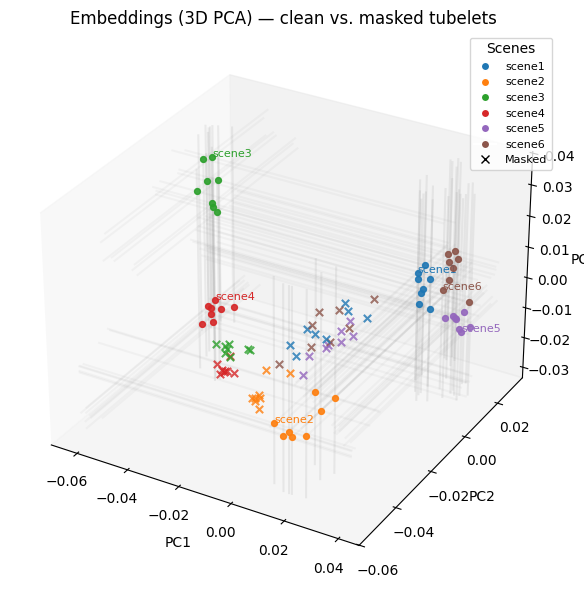

In [100]:

# 3d plotting

# Colors by scene
scenes_unique = sorted({m[0] for m in meta})
palette = plt.cm.get_cmap('tab10').colors
color_map = {s: palette[i % len(palette)] for i, s in enumerate(scenes_unique)}

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')

# ground-truth embeddings (circles)
for (x, y, z), (scene, t_idx) in zip(emb_3d, meta):
    ax.scatter(x, y, z, color=color_map[scene], s=18, alpha=0.9)

# masked embeddings (x markers)
if emb_3d_masked is not None:
    for (x, y, z), (scene, _) in zip(emb_3d_masked, meta):
        ax.scatter(x, y, z, color=color_map[scene], s=28, alpha=0.8,
                   marker='x', linewidths=1.5)

# annotate representative point per scene
for scene in scenes_unique:
    k = next((i for i, m in enumerate(meta) if m[0] == scene), None)
    if k is not None:
        xi, yi, zi = emb_3d[k]
        ax.text(xi, yi, zi, scene, fontsize=8, color=color_map[scene])

ax.grid(True)
for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
    try:
        axis._axinfo["grid"]["linewidth"] = 0.0
    except Exception:
        pass

# faint guides
mins, maxs = emb_3d.min(axis=0), emb_3d.max(axis=0)
for x, y, z in emb_3d:
    ax.plot([x, x], [y, y], [mins[2], maxs[2]], color='gray', alpha=0.12)
    ax.plot([x, x], [mins[1], maxs[1]], [z, z], color='gray', alpha=0.06)
    ax.plot([mins[0], maxs[0]], [y, y], [z, z], color='gray', alpha=0.06)

handles = [plt.Line2D([0],[0], marker='o', color='w', label=s,
                      markerfacecolor=color_map[s], markersize=6)
           for s in scenes_unique]
if emb_3d_masked is not None:
    handles.append(plt.Line2D([0],[0], marker='x', color='k', linewidth=0,
                              markeredgecolor='k', label='Masked'))
ax.legend(handles=handles, title='Scenes', loc='best', fontsize=8)

ax.set_title('Embeddings (3D PCA) — clean vs. masked tubelets')
ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
plt.tight_layout()
plt.show()



/var/folders/61/qgw87yz91l7fqxmfslbk4wd40000gn/T/ipykernel_9459/678282992.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab20').colors  # list of 10 RGBA colors


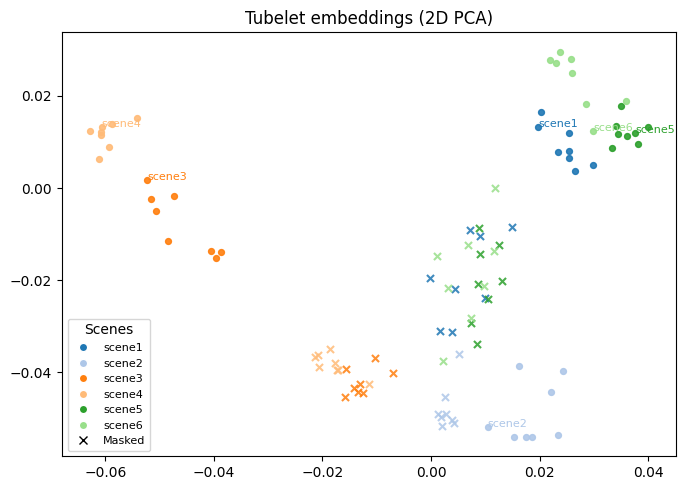

In [101]:

# 2d plotting

scenes_unique = sorted({m[0] for m in tubelet_meta})
palette = plt.cm.get_cmap('tab20').colors  # list of 10 RGBA colors
color_map = {s: palette[i % len(palette)] for i, s in enumerate(scenes_unique)}

plt.figure(figsize=(7, 5))
for (x, y), (scene, t_idx) in zip(emb_2d, tubelet_meta):
    plt.scatter(x, y, color=color_map[scene], s=18, alpha=0.9)

if emb_2d_masked is not None:
    for (x, y), (scene, _) in zip(emb_2d_masked, tubelet_meta):
        plt.scatter(x, y, color=color_map[scene], s=26, marker='x', linewidths=1.5,
                    alpha=0.85)

plt.title("Tubelet embeddings (2D PCA)")

for scene in scenes_unique:
    k = next(i for i, m in enumerate(tubelet_meta) if m[0] == scene)
    x, y = emb_2d[k]
    plt.text(x, y, scene, fontsize=8, color=color_map[scene])

handles = [plt.Line2D([0], [0], marker='o', color='w', label=s,
                      markerfacecolor=color_map[s], markersize=6)
           for s in scenes_unique]
if emb_2d_masked is not None:
    handles.append(plt.Line2D([0], [0], marker='x', color='k', linewidth=0,
                              markeredgecolor='k', label='Masked'))
plt.legend(handles=handles, loc='best', fontsize=8, title='Scenes')
plt.tight_layout()
plt.show()



### Predictor Head

In [102]:

# data prep for pooled predictor
clean_emb = tubelet_embds.astype(np.float32)
masked_emb = tubelet_embds_masked.astype(np.float32)
mask_tokens = tubelet_mask_tokens.astype(np.bool_) # True for non-zero values, False for rest (do this for predictor)
meta_arr = np.array(tubelet_meta)

# basic features about how much was masked per tubelet (optional)
mask_fraction = mask_tokens.reshape(mask_tokens.shape[0], -1).mean(axis=1, keepdims=True).astype(np.float32)

regressor_data = []
for idx in range(len(clean_emb)):
    sample = {
        'scene': meta_arr[idx, 0],
        'tubelet_idx': int(meta_arr[idx, 1]),
        'clean_emb': clean_emb[idx],
        'masked_emb': masked_emb[idx],
        'mask_tokens': mask_tokens[idx],
        'mask_fraction': mask_fraction[idx, 0]
    }
    regressor_data.append(sample)

print(f'Regressor dataset: {len(regressor_data)} samples, emb dim {clean_emb.shape[1]}')



Regressor dataset: 48 samples, emb dim 1024


In [103]:
# freezing model (not updaing model weights)
for param in model_hf.parameters():
    param.requires_grad = False

model_hf.eval() # will set to train() during training

# will take in (1024, ) embedding and output (1024, ) embedding
regressor = nn.Sequential(
    nn.Linear(1024, 1024),
    nn.GELU(),
    nn.Dropout(0.1),
    nn.Linear(1024, 1024)
)

print("model_hf parameters frozen:", all(not p.requires_grad for p in model_hf.parameters()))
print("Regressor architecture:")
print(regressor)

model_hf parameters frozen: True
Regressor architecture:
Sequential(
  (0): Linear(in_features=1024, out_features=1024, bias=True)
  (1): GELU(approximate='none')
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=1024, out_features=1024, bias=True)
)


In [145]:
# class definitions

class TubeletDataset(Dataset):
    def __init__(self, records):
        self.records = records

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        rec = self.records[idx]
        return {
            "masked": torch.from_numpy(rec["masked_emb"]),
            "clean": torch.from_numpy(rec["clean_emb"]),
            "mask_frac": torch.tensor(rec["mask_fraction"], dtype=torch.float32),
        }
    
class PredictorHead(nn.Module):
    def __init__(self, emb_dim=1024):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(emb_dim + 1, emb_dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(emb_dim, emb_dim),
        )

    def forward(self, masked_emb, mask_frac):
        x = torch.cat([masked_emb, mask_frac.unsqueeze(-1)], dim=1)
        pred = self.net(x)
        return nn.functional.normalize(pred, dim=1)

In [146]:
# init dataset
dataset = TubeletDataset(regressor_data)
train_size = int(0.8*len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset ,[train_size, val_size])

train_loader = DataLoader(train_ds, batch_size = 8, shuffle = True)
val_loader = DataLoader(val_ds, batch_size = 8)

In [147]:
# predictor head 
head = PredictorHead(emb_dim=clean_emb.shape[1]).to("mps")
optimizer = torch.optim.AdamW(head.parameters(), lr = 1e-4)
criterion = nn.MSELoss()

num_epochs = 10

# training loop
for epoch in range(num_epochs):
    # training head using our 
    head.train()
    for batch in train_loader:
        masked = batch["masked"].to(head.net[0].weight.device)
        clean = batch["clean"].to(head.net[0].weight.device)
        frac = batch["mask_frac"].to(head.net[0].weight.device)
        pred = head(masked, frac)
        target = nn.functional.normalize(clean, dim = 1)
        loss = criterion(pred, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    head.eval()
    with torch.no_grad():
        val_losses = []
        for batch in val_loader:
            masked = batch["masked"].to(head.net[0].weight.device)
            clean = batch["clean"].to(head.net[0].weight.device)
            frac = batch["mask_frac"].to(head.net[0].weight.device)
            pred = head(masked, frac)
            target = nn.functional.normalize(clean, dim = 1)
            val_losses.append(criterion(pred, target).item())
        print(f"Epoch {epoch}: val loss {sum(val_losses)/len(val_losses):.4f}")


Epoch 0: val loss 0.0010
Epoch 1: val loss 0.0005
Epoch 2: val loss 0.0003
Epoch 3: val loss 0.0002
Epoch 4: val loss 0.0002
Epoch 5: val loss 0.0001
Epoch 6: val loss 0.0001
Epoch 7: val loss 0.0001
Epoch 8: val loss 0.0001
Epoch 9: val loss 0.0001


In [148]:

# predictor inference — generate recovered embeddings
head.eval()
device = next(head.parameters()).device

masked_tensor = torch.from_numpy(tubelet_embds_masked.astype(np.float32)).to(device)
mask_frac_tensor = torch.tensor(mask_fraction.squeeze(), dtype=torch.float32, device=device)

with torch.no_grad():
    pred_emb_tensor = head(masked_tensor, mask_frac_tensor)

tubelet_embds_pred = pred_emb_tensor.cpu().numpy()
print('predicted embeddings tensor', tubelet_embds_pred.shape)



predicted embeddings tensor (48, 1024)


In [149]:
def l2_normalize(arr: np.ndarray) -> np.ndarray:
         denom = np.maximum(np.linalg.norm(arr, axis=1, keepdims=True), 1e-12)
         return arr / denom

tubelet_embds_norm = l2_normalize(tubelet_embds)
tubelet_embds_masked_norm = l2_normalize(tubelet_embds_masked)
tubelet_embds_pred_norm = l2_normalize(tubelet_embds_pred)

# PCA
pca3 = sk.decomposition.PCA(n_components=3)
emb_3d = pca3.fit_transform(tubelet_embds_norm)

pca2 = sk.decomposition.PCA(n_components=2)
emb_2d = pca2.fit_transform(tubelet_embds_norm)

# Reuse the fitted PCA to project masked/predicted embeddings
emb_3d_masked = pca3.transform(tubelet_embds_masked_norm)
emb_2d_masked = pca2.transform(tubelet_embds_masked_norm)

emb_3d_pred = pca3.transform(tubelet_embds_pred_norm)
emb_2d_pred = pca2.transform(tubelet_embds_pred_norm)


/var/folders/61/qgw87yz91l7fqxmfslbk4wd40000gn/T/ipykernel_9459/4122830505.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab10').colors


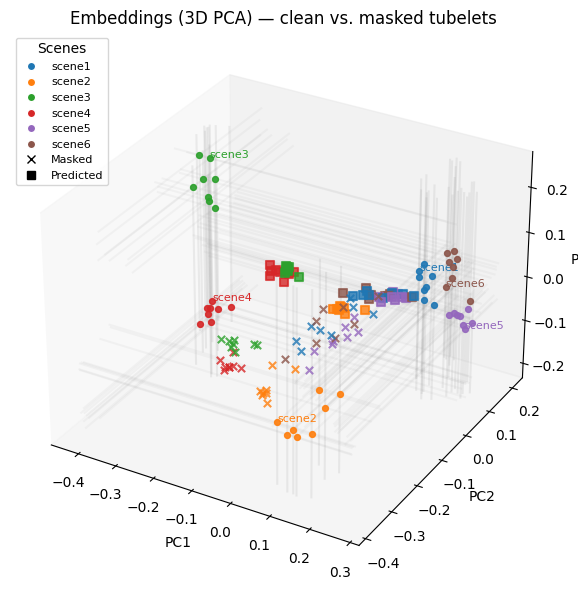

In [164]:

# 3d plotting

# Colors by scene
scenes_unique = sorted({m[0] for m in meta})
palette = plt.cm.get_cmap('tab10').colors
color_map = {s: palette[i % len(palette)] for i, s in enumerate(scenes_unique)}

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')

# ground-truth embeddings (circles)
for (x, y, z), (scene, t_idx) in zip(emb_3d, meta):
    ax.scatter(x, y, z, color=color_map[scene], s=18, alpha=0.9)

# masked embeddings (x markers)
if emb_3d_masked is not None:
    for (x, y, z), (scene, _) in zip(emb_3d_masked, meta):
        ax.scatter(x, y, z, color=color_map[scene], s=28, alpha=0.8,
                   marker='x', linewidths=1.5)

if emb_3d_pred is not None:
    for (x, y, z), (scene, _) in zip(emb_3d_pred, meta):
        ax.scatter(x, y, z, color=color_map[scene], s=28, alpha=0.8,
                   marker='s', linewidths=1.5)

# annotate representative point per scene
for scene in scenes_unique:
    k = next((i for i, m in enumerate(meta) if m[0] == scene), None)
    if k is not None:
        xi, yi, zi = emb_3d[k]
        ax.text(xi, yi, zi, scene, fontsize=8, color=color_map[scene])

ax.grid(True)
for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
    try:
        axis._axinfo["grid"]["linewidth"] = 0.0
    except Exception:
        pass

# faint guides
mins, maxs = emb_3d.min(axis=0), emb_3d.max(axis=0)
for x, y, z in emb_3d:
    ax.plot([x, x], [y, y], [mins[2], maxs[2]], color='gray', alpha=0.12)
    ax.plot([x, x], [mins[1], maxs[1]], [z, z], color='gray', alpha=0.06)
    ax.plot([mins[0], maxs[0]], [y, y], [z, z], color='gray', alpha=0.06)

handles = [plt.Line2D([0],[0], marker='o', color='w', label=s,
                      markerfacecolor=color_map[s], markersize=6)
           for s in scenes_unique]
if emb_3d_masked is not None:
    handles.append(plt.Line2D([0],[0], marker='x', color='k', linewidth=0,
                              markeredgecolor='k', label='Masked'))
if emb_3d_pred is not None:
    handles.append(plt.Line2D([0],[0], marker='s', color='k', linewidth=0,
                              markeredgecolor='k', label='Predicted'))
ax.legend(handles=handles, title='Scenes', loc='best', fontsize=8)

ax.set_title('Embeddings (3D PCA) — clean vs. masked tubelets')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.tight_layout()
plt.show()

/var/folders/61/qgw87yz91l7fqxmfslbk4wd40000gn/T/ipykernel_9459/3977529699.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab20').colors


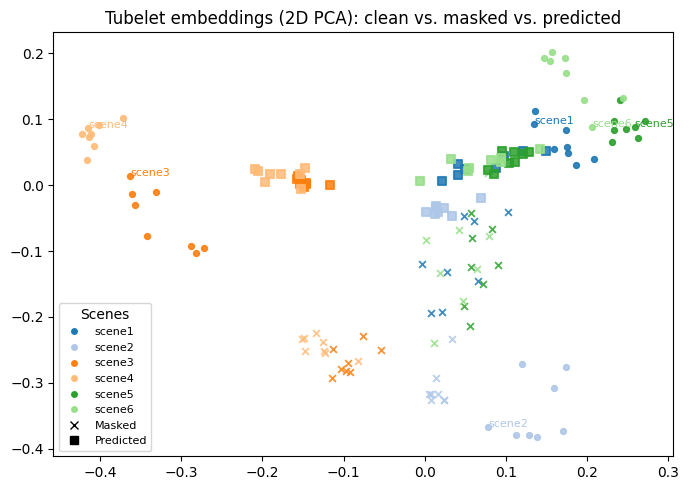

In [165]:

# 2d plotting
scenes_unique = sorted({m[0] for m in tubelet_meta})
palette = plt.cm.get_cmap('tab20').colors
color_map = {s: palette[i % len(palette)] for i, s in enumerate(scenes_unique)}

plt.figure(figsize=(7, 5))
for (x, y), (scene, _) in zip(emb_2d, tubelet_meta):
    plt.scatter(x, y, color=color_map[scene], s=18, alpha=0.9)

if emb_2d_masked is not None:
    for (x, y), (scene, _) in zip(emb_2d_masked, tubelet_meta):
        plt.scatter(x, y, color=color_map[scene], s=24, marker='x',
                    linewidths=1.3, alpha=0.85)

if emb_2d_pred is not None:
    for (x, y), (scene, _) in zip(emb_2d_pred, tubelet_meta):
        plt.scatter(x, y, color=color_map[scene], s=28, marker='s',
                    linewidths=1.5, alpha=0.85)

plt.title("Tubelet embeddings (2D PCA): clean vs. masked vs. predicted")

for scene in scenes_unique:
    k = next(i for i, m in enumerate(tubelet_meta) if m[0] == scene)
    x, y = emb_2d[k]
    plt.text(x, y, scene, fontsize=8, color=color_map[scene])

handles = [plt.Line2D([0], [0], marker='o', color='w', label=s,
                    markerfacecolor=color_map[s], markersize=6)
            for s in scenes_unique]
if emb_2d_masked is not None:
    handles.append(plt.Line2D([0], [0], marker='x', color='k', linewidth=0,
                            markeredgecolor='k', label='Masked'))
if emb_2d_pred is not None:
    handles.append(plt.Line2D([0], [0], marker='s', color='k', linewidth=0,
                            markeredgecolor='k', label='Predicted'))

plt.legend(handles=handles, loc='best', fontsize=8, title='Scenes')
plt.tight_layout()
plt.show()



In [166]:
pred_norm = l2_normalize(tubelet_embds_pred)
clean_norm = l2_normalize(tubelet_embds)

cos_sims = np.diag(cosine_similarity(pred_norm, clean_norm))
print(f"Mean cosine similarity: {cos_sims.mean():.4f} ± {cos_sims.std():.4f}")
for scene in sorted({m[0] for m in tubelet_meta}):
    idxs = [i for i, m in enumerate(tubelet_meta) if m[0] == scene]
    print(f"{scene}: {cos_sims[idxs].mean():.4f}")

Mean cosine similarity: 0.9492 ± 0.0182
scene1: 0.9710
scene2: 0.9253
scene3: 0.9436
scene4: 0.9335
scene5: 0.9592
scene6: 0.9624


In [167]:
pred_norm = l2_normalize(tubelet_embds_masked)
clean_norm = l2_normalize(tubelet_embds)

cos_sims = np.diag(cosine_similarity(pred_norm, clean_norm))
print(f"Mean cosine similarity: {cos_sims.mean():.4f} ± {cos_sims.std():.4f}")
for scene in sorted({m[0] for m in tubelet_meta}):
    idxs = [i for i, m in enumerate(tubelet_meta) if m[0] == scene]
    print(f"{scene}: {cos_sims[idxs].mean():.4f}")

Mean cosine similarity: 0.6701 ± 0.0588
scene1: 0.7236
scene2: 0.6862
scene3: 0.6172
scene4: 0.6025
scene5: 0.7122
scene6: 0.6787
